In [1]:
import multimodal_cci as mmcci
import scanpy as sc
import numpy as np

#### Load stLearn data objects

In [2]:
brain_aged_tech1 = [sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1C_CCI.h5ad"),
                sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1D_CCI.h5ad"),
                sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1B_CCI.h5ad"),
                sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1D_CCI.h5ad")]

brain_young_tech1 = [sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1A_CCI.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1B_CCI.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1A_CCI.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1C_CCI.h5ad")]

brain_aged_tech2 = [sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_A1_CCI_bin80.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_A4_CCI_bin80.h5ad")]
brain_young_tech2 = [sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_Y1_CCI_bin80.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_Y4_CCI_bin80.h5ad")]

brain_aged_tech1_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_aged_tech1]
brain_young_tech1_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_young_tech1]
brain_aged_tech2_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_aged_tech2]
brain_young_tech2_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_young_tech2]

brain_aged_tech1_sizes = [sample.shape[0] for sample in brain_aged_tech1]
brain_young_tech1_sizes = [sample.shape[0] for sample in brain_young_tech1]
brain_aged_tech2_sizes = [sample.shape[0] for sample in brain_aged_tech2]
brain_young_tech2_sizes = [sample.shape[0] for sample in brain_young_tech2]

#### Normalise each group of samples

In [3]:
brain_aged_tech1_normalised = mmcci.it.normalise_samples_to_target(brain_aged_tech1_cci, brain_aged_tech1_sizes, target=brain_young_tech1_sizes[0])
brain_young_tech1_normalised = mmcci.it.normalise_samples_to_target(brain_young_tech1_cci, brain_young_tech1_sizes, target=brain_young_tech1_sizes[0])
brain_aged_tech2_normalised = mmcci.it.normalise_samples_to_target(brain_aged_tech2_cci, brain_aged_tech2_sizes, target=brain_young_tech2_sizes[0])
brain_young_tech2_normalised = mmcci.it.normalise_samples_to_target(brain_young_tech2_cci, brain_young_tech2_sizes, target=brain_young_tech2_sizes[0])

#### Subset to only LR pairs present in majority of samples

In [4]:
aged_lr_pairs = mmcci.it.get_majority_lr_pairs(brain_aged_tech1_normalised + brain_aged_tech2_normalised)
young_lr_pairs = mmcci.it.get_majority_lr_pairs(brain_young_tech1_normalised + brain_young_tech2_normalised)

all_lr_pairs = aged_lr_pairs + young_lr_pairs

#### Calculate average value of each LR pair across each group

In [5]:
brain_aged_tech1_avg = mmcci.it.get_avg_lr_pairs(brain_aged_tech1_normalised, all_lr_pairs)
brain_young_tech1_avg = mmcci.it.get_avg_lr_pairs(brain_young_tech1_normalised, all_lr_pairs)
brain_aged_tech2_avg = mmcci.it.get_avg_lr_pairs(brain_aged_tech2_normalised, all_lr_pairs)
brain_young_tech2_avg = mmcci.it.get_avg_lr_pairs(brain_young_tech2_normalised, all_lr_pairs)

#### Normalise samples between technologies

In [6]:
normalised = mmcci.it.normalise_samples_between_tech([[brain_aged_tech1_avg, brain_young_tech1_avg],
                                             [brain_aged_tech2_avg, brain_young_tech2_avg]])

#### Integrate between technologies for both groups

In [7]:
normalised = np.array(normalised).T.tolist() # Transpose to get lists of groups instead of techs
aged_integrated = mmcci.it.integrate_between_tech(normalised[0])
young_integrated = mmcci.it.integrate_between_tech(normalised[1])

#### Calculate overall interactions network per group

In [8]:
aged_overall = mmcci.it.calculate_overall_interactions(aged_integrated)
young_overall = mmcci.it.calculate_overall_interactions(young_integrated)

#### Rank LR pairs based on dissimilarity between groups

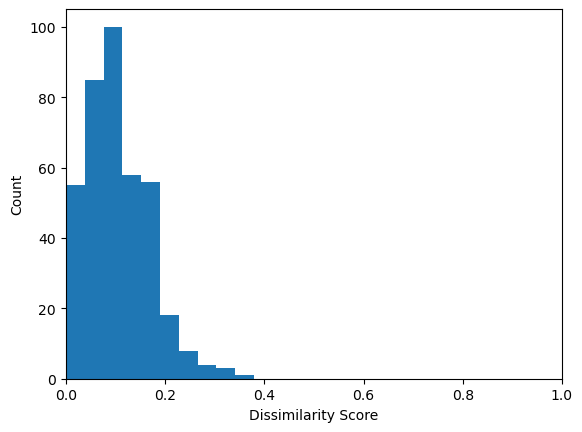

Overall Network Aged vs Young Dissimilarity Score is: 0.36464642821428406

Top 10 Dissimilar LR Pairs: ['A2m_Lrp1', 'Psap_Gpr37l1', 'Vim_Cd44', 'Apoe_Lrp8', 'Fgf2_Sdc4', 'Calr_Itga3', 'Sema6d_Tyrobp', 'Mdk_Ptprz1', 'Mdk_Itgb1', 'Timp1_Cd63']


In [9]:
dissimilarity_scores = mmcci.it.calculate_dissim(aged_integrated, young_integrated)
mmcci.plt.dissim_hist(dissimilarity_scores)
    
## Sort LR Pairs from high to low dissimilarities
print("Overall Network Aged vs Young Dissimilarity Score is: " + str(mmcci.sc.dissimilarity_score(aged_overall, young_overall)))

sorted_pairs = sorted(dissimilarity_scores, key=dissimilarity_scores.get, reverse=True)
print("\nTop 10 Dissimilar LR Pairs:", sorted_pairs[:10])

#### Plot highly dissimilar pairs between groups

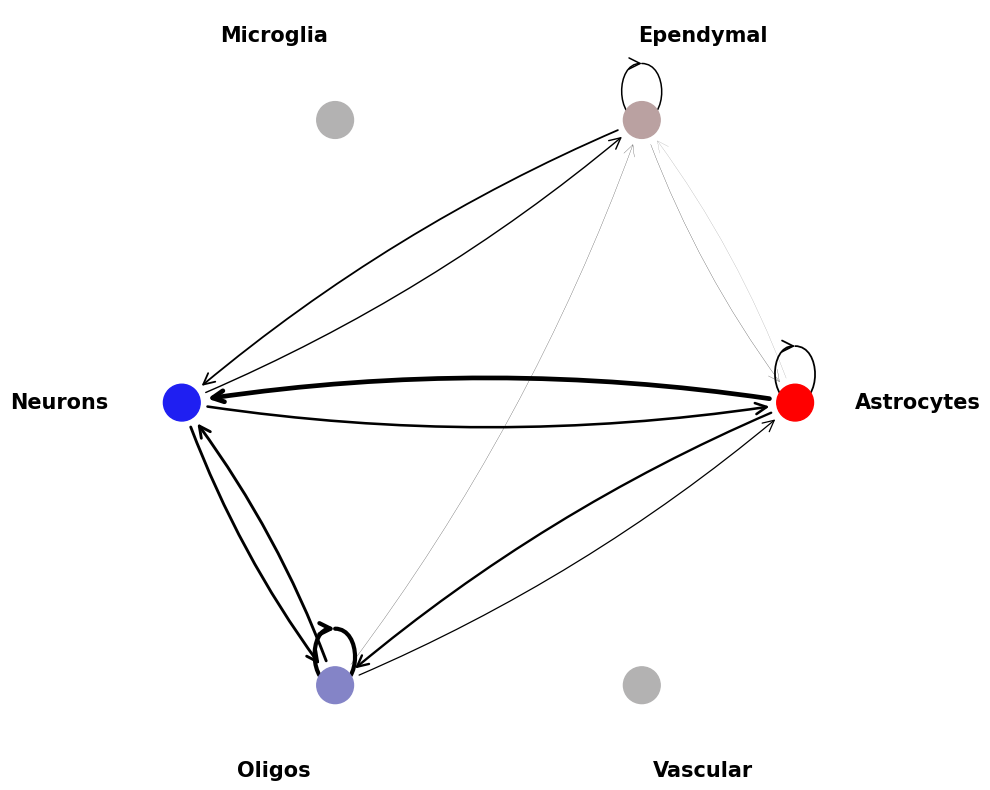

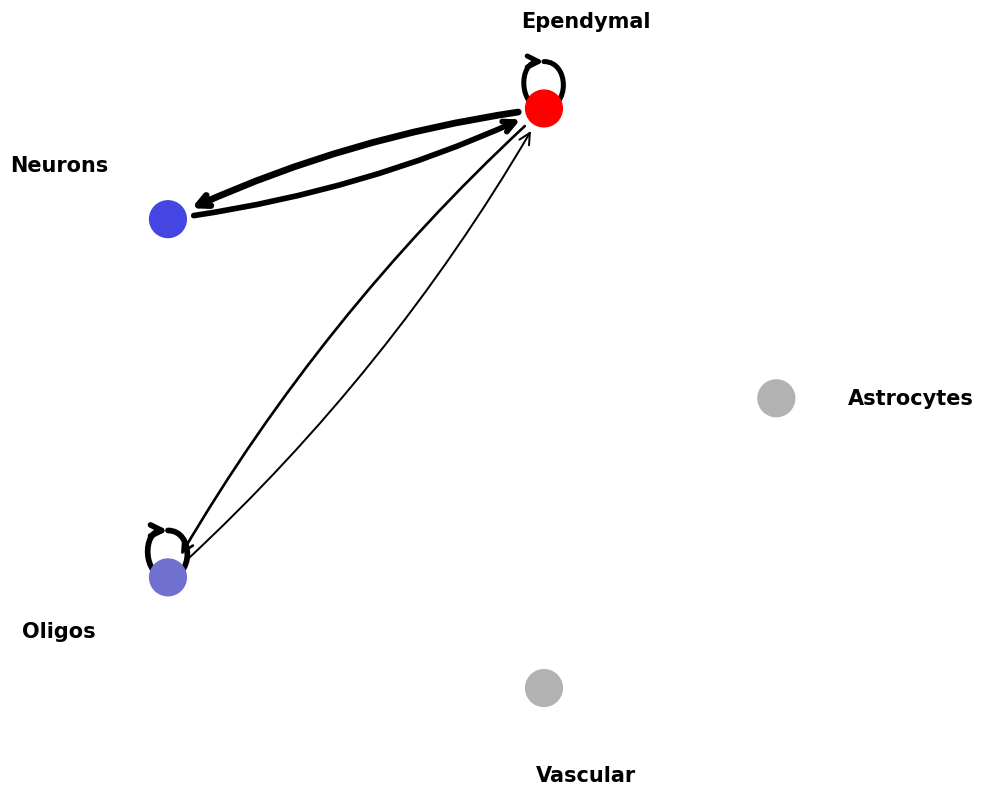

In [10]:
mmcci.plt.network_plot(aged_integrated['A2m_Lrp1'])
mmcci.plt.network_plot(young_integrated['A2m_Lrp1'])

#### Calculate p values for significance changes between groups

In [11]:
p_values = mmcci.sc.perm_test(aged_overall, young_overall)
p_values

,Astrocytes,Ependymal,Immune,Microglia,Neurons,Oligos,Vascular
Astrocytes,0.092030,0.387830,0.417695,0.418805,0.152790,0.173585,0.387470
Ependymal,0.389295,0.040920,0.418445,0.416350,0.153550,0.286035,0.396845
Immune,0.419520,0.416280,0.421235,0.416745,0.418065,0.418785,0.418970
Microglia,0.417940,0.418315,0.417885,0.419580,0.417345,0.419220,0.421090
Neurons,0.152560,0.153140,0.418170,0.419145,0.050255,0.142375,0.347375
Oligos,0.214350,0.265155,0.418770,0.418630,0.172775,0.010310,0.419095
Vascular,0.326385,0.397530,0.418875,0.417590,0.286115,0.418670,0.419785


#### Plot aged and young overall networks

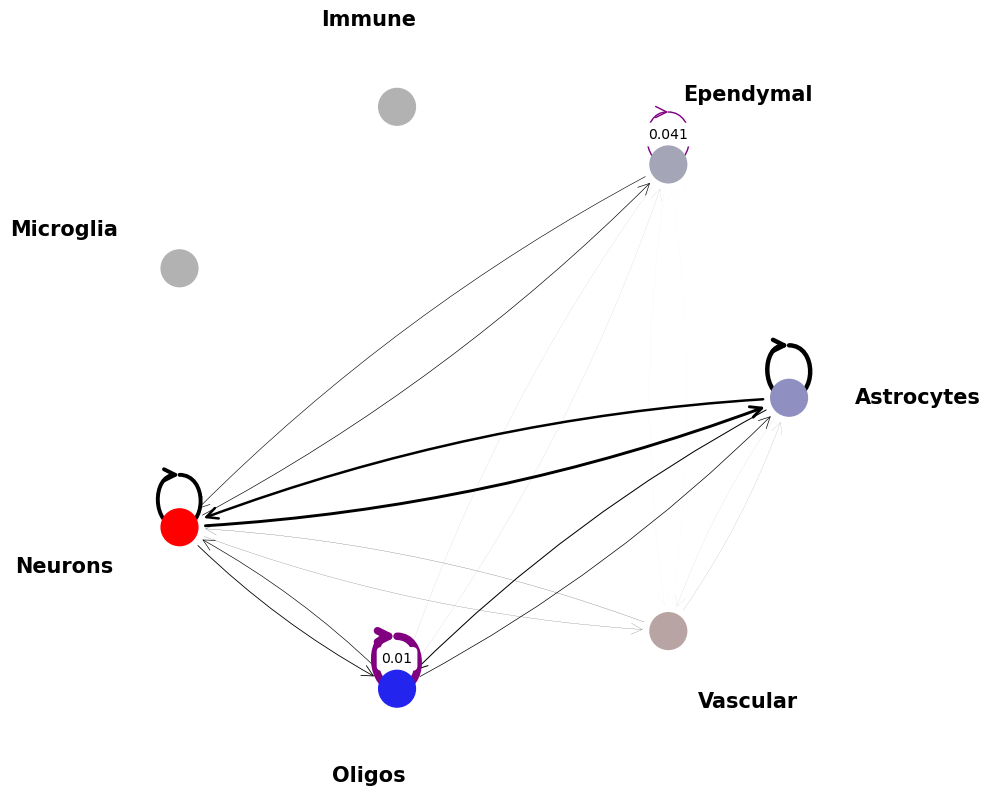

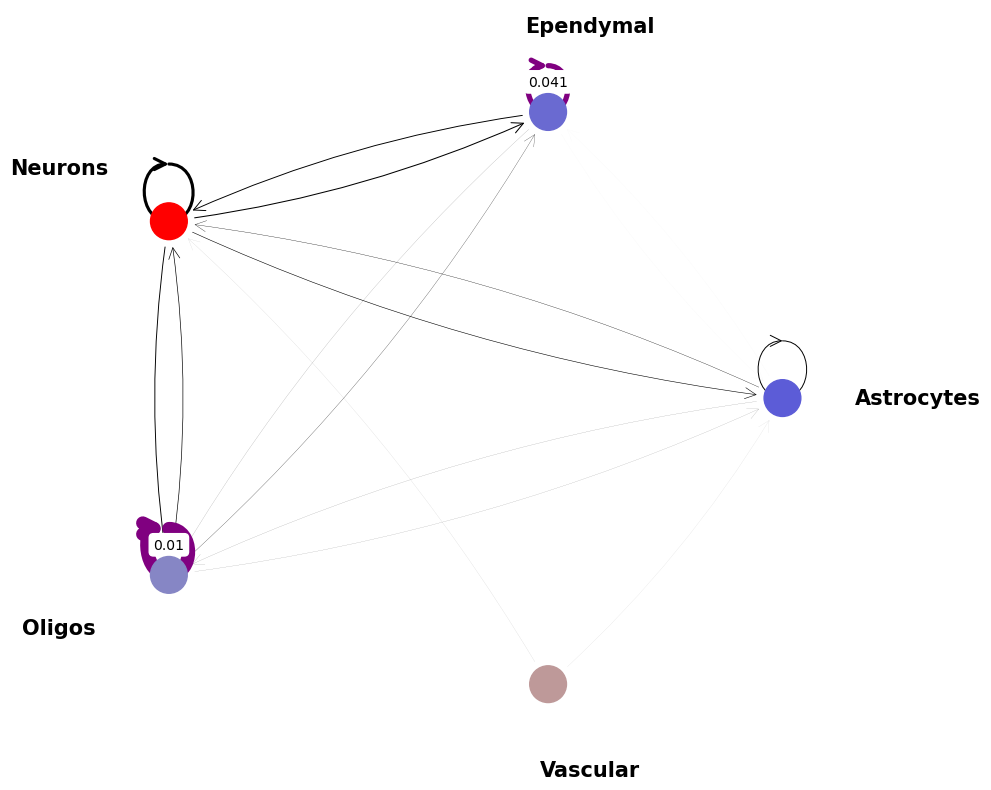

In [12]:
mmcci.plt.network_plot(aged_overall, p_values)
mmcci.plt.network_plot(young_overall, p_values)

#### Get LR pairs from Vascular to Astrocytes

In [13]:
vasc_astr_lrs = mmcci.it.get_lrs_per_celltype([aged_integrated, young_integrated], "Vascular", "Astrocytes")
print("LR pairs from vascular to astrocytes in aged")
print(vasc_astr_lrs['sample1'])
print("\nLR pairs from vascular to astrocytes in young")
print(vasc_astr_lrs['sample2'])

LR pairs from vascular to astrocytes in aged
{'Thbs1_Cd47': 0.10876708547700892, 'Dag1_Lama4': 0.1087523519003955, 'Agrn_Dag1': 0.08759673037439152, 'Psen1_Notch3': 0.07776899869910404, 'Fbn1_Itgb1': 0.07689952549875538, 'Lama1_Itga1': 0.0751598764276216, 'Pf4_Fgfr2': 0.07340314613183953, 'Bsg_Slc16a7': 0.07073891764197272, 'Sfrp1_Fzd2': 0.06346795504335848, 'Jag2_Notch3': 0.057572408681504705, 'Col18a1_Kdr': 0.05671672364456953, 'Pdgfc_Pdgfrb': 0.05631208637806493, 'Lamb1_Itga6': 0.04821399481972648, 'Pf4_Ldlr': 0.038630199281686796}

LR pairs from vascular to astrocytes in young
{'Serpinf1_Plxdc2': 1.0}


#### Cluster aged and young lr pairs

In [14]:
aged_clusters = mmcci.it.lr_clustering(aged_integrated, n_clusters=4)
aged_integrated_clusters = mmcci.it.subset_clusters(aged_integrated, aged_clusters)
aged_overall_clusters = mmcci.it.calculate_cluster_interactions(aged_integrated_clusters)

Processing: 100%|██████████| 530/530 [01:48<00:00,  4.90it/s]



cluster0: Contains 149 LR pairs


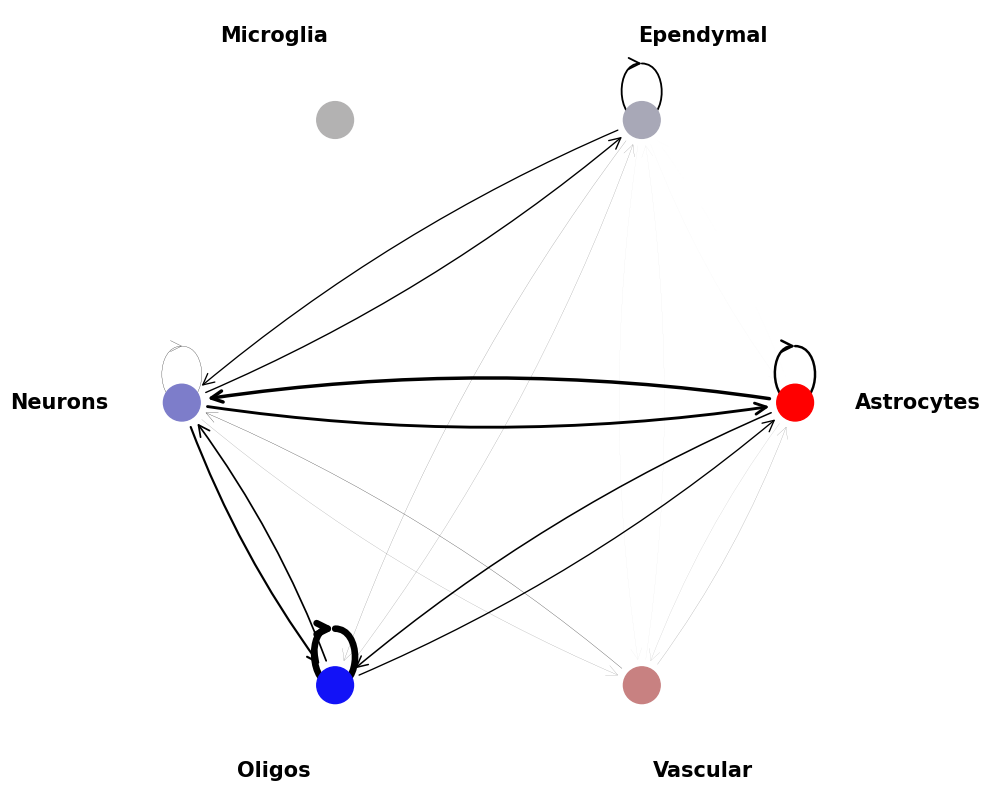


cluster1: Contains 189 LR pairs


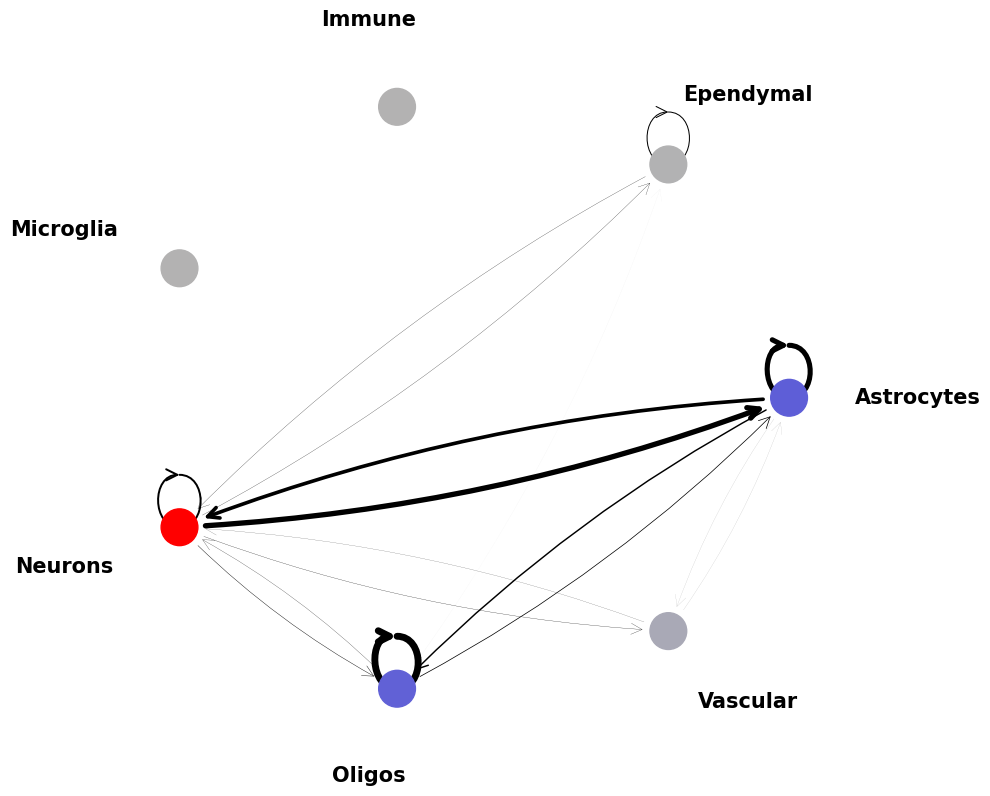


cluster2: Contains 19 LR pairs


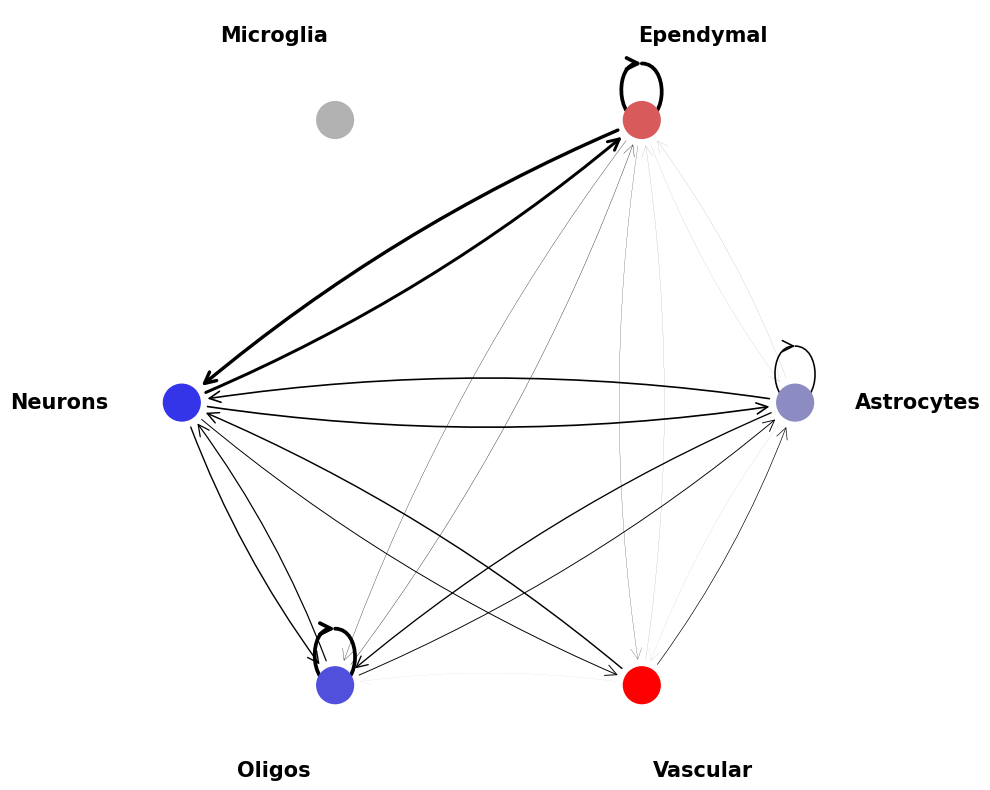


cluster3: Contains 173 LR pairs


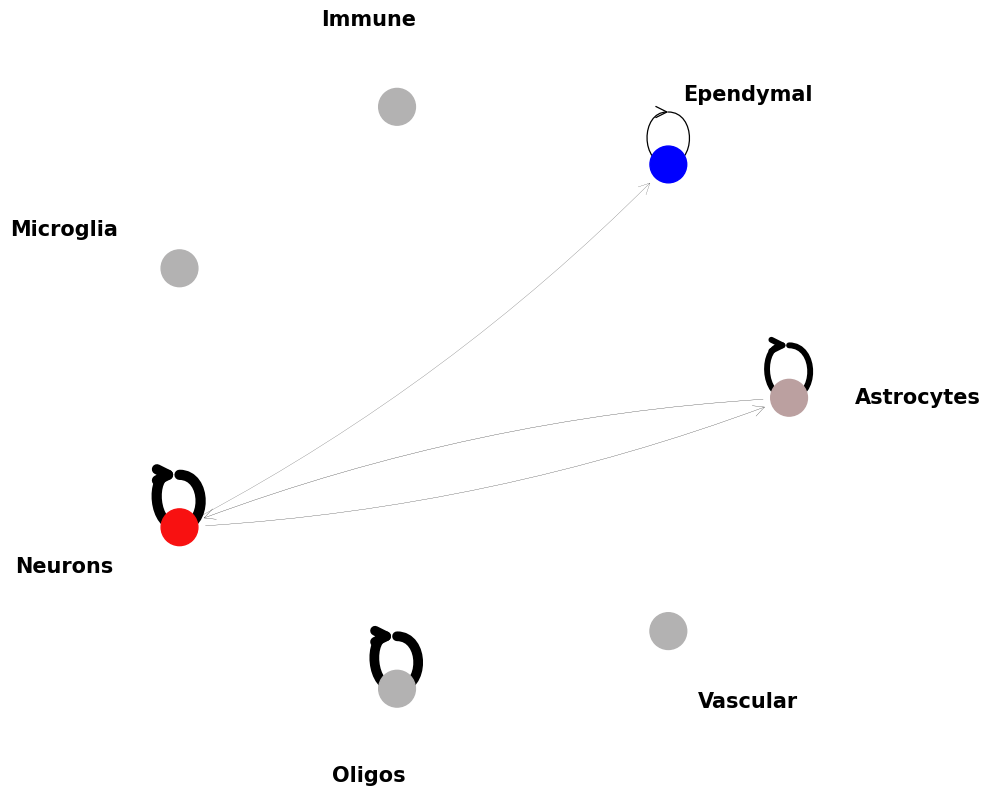

In [15]:
for cluster, matrix in aged_overall_clusters.items():
    print("\ncluster" + str(cluster) + ": Contains " + str(len(aged_integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.network_plot(matrix)

Processing: 100%|██████████| 411/411 [01:03<00:00,  6.44it/s]


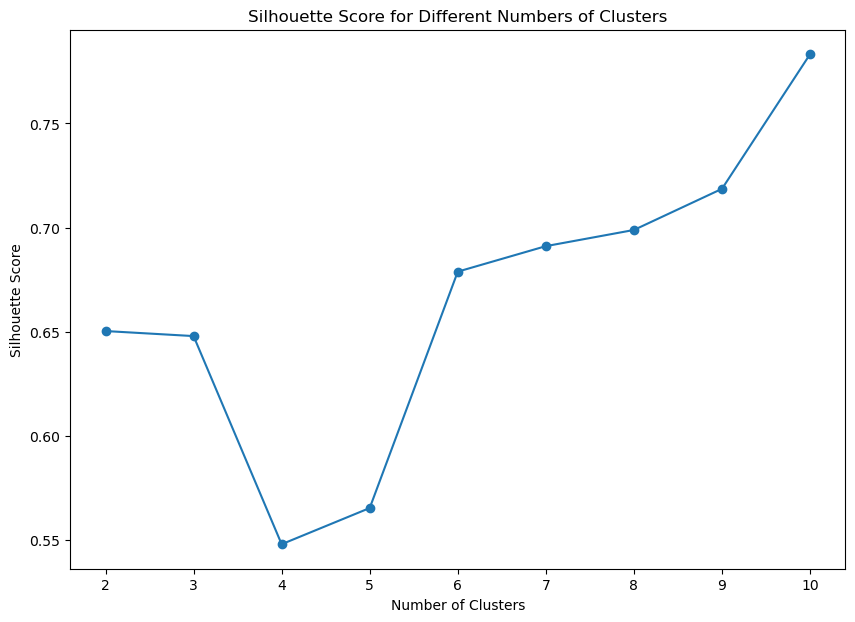

In [16]:
young_clusters = mmcci.it.lr_clustering(young_integrated, n_clusters=0)
young_integrated_clusters = mmcci.it.subset_clusters(young_integrated, young_clusters)
young_overall_clusters = mmcci.it.calculate_cluster_interactions(young_integrated_clusters)


cluster0: Contains 12 LR pairs


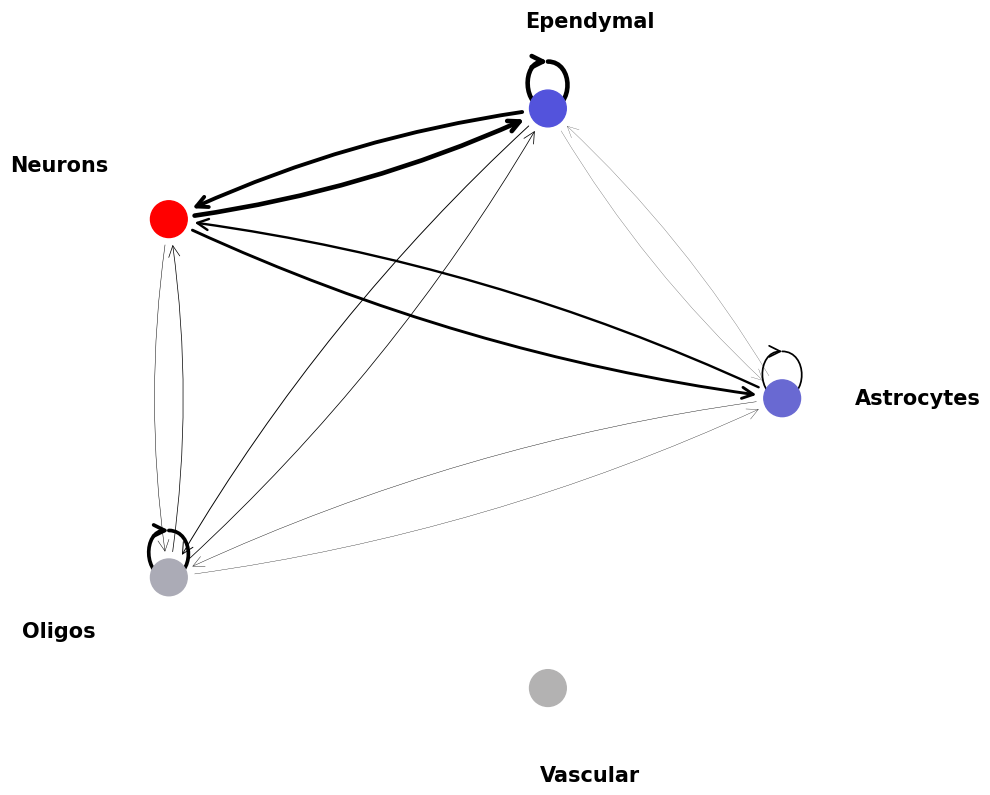


cluster1: Contains 16 LR pairs


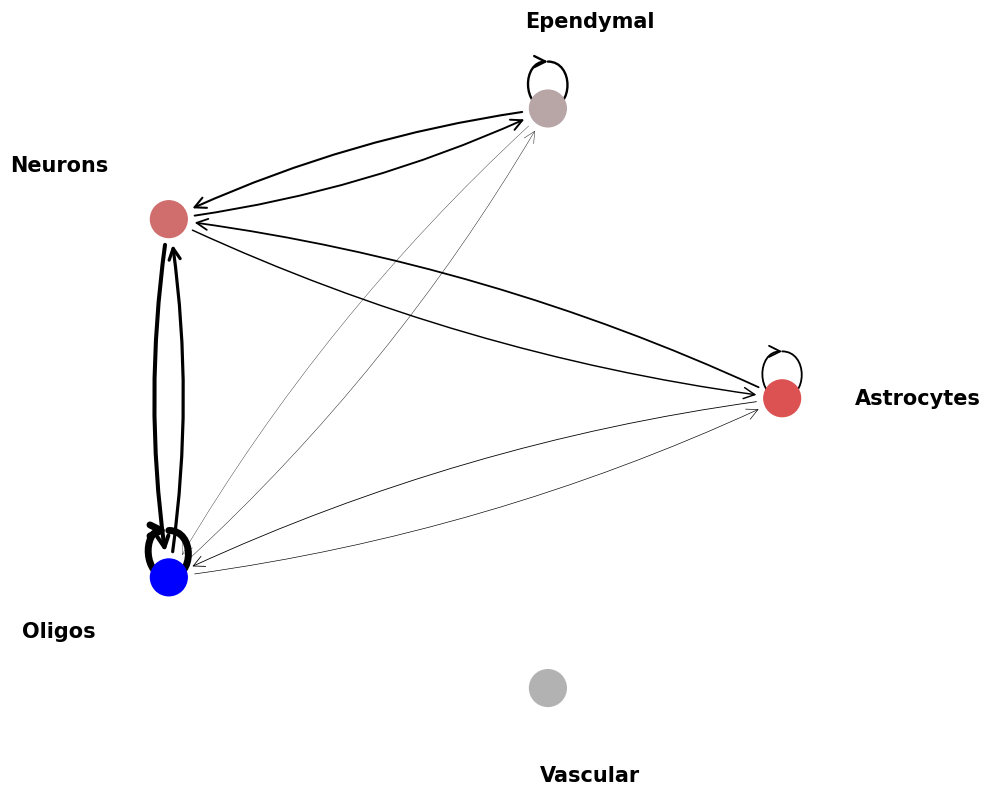


cluster2: Contains 31 LR pairs


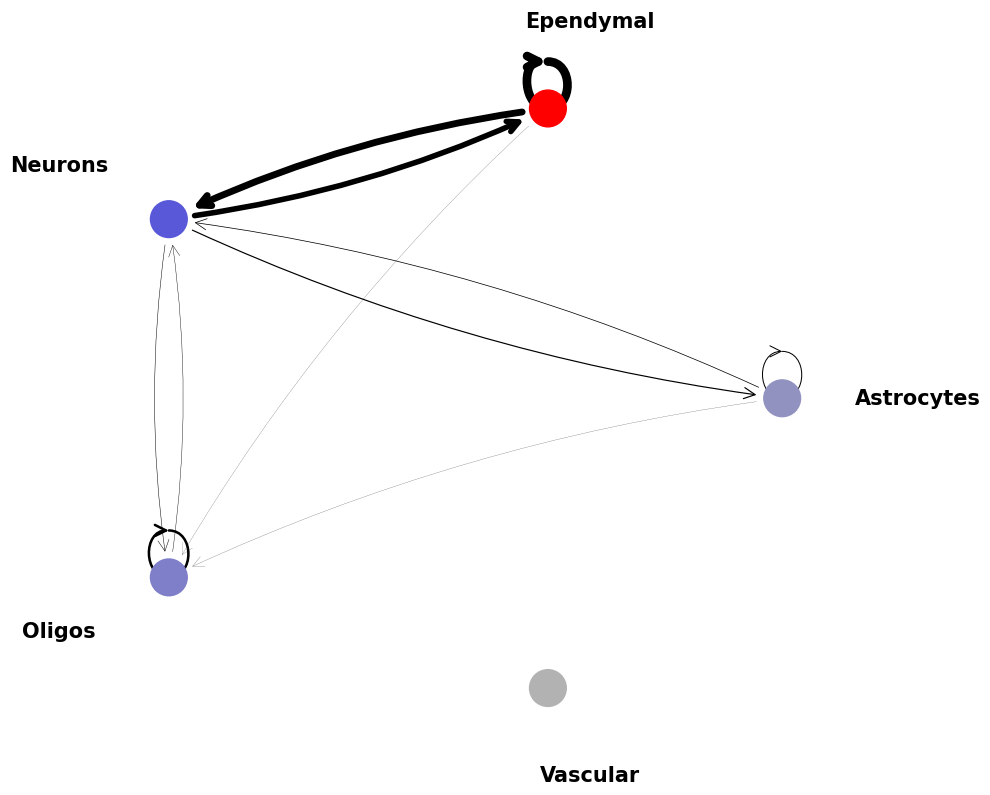


cluster3: Contains 48 LR pairs


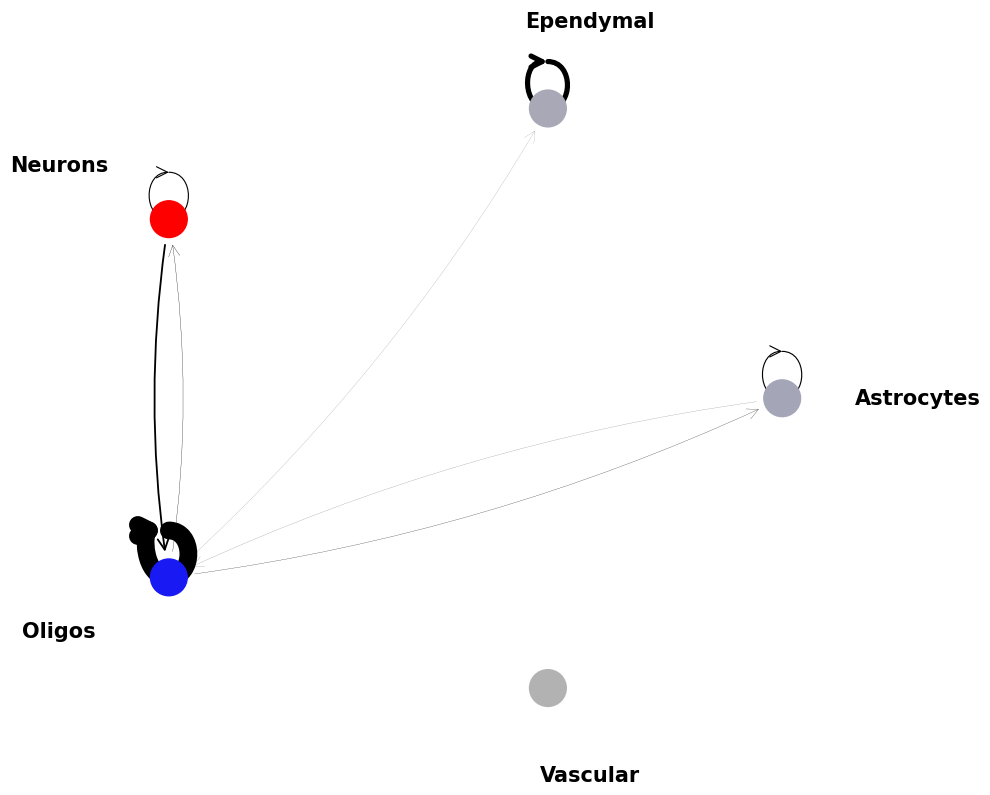


cluster4: Contains 22 LR pairs


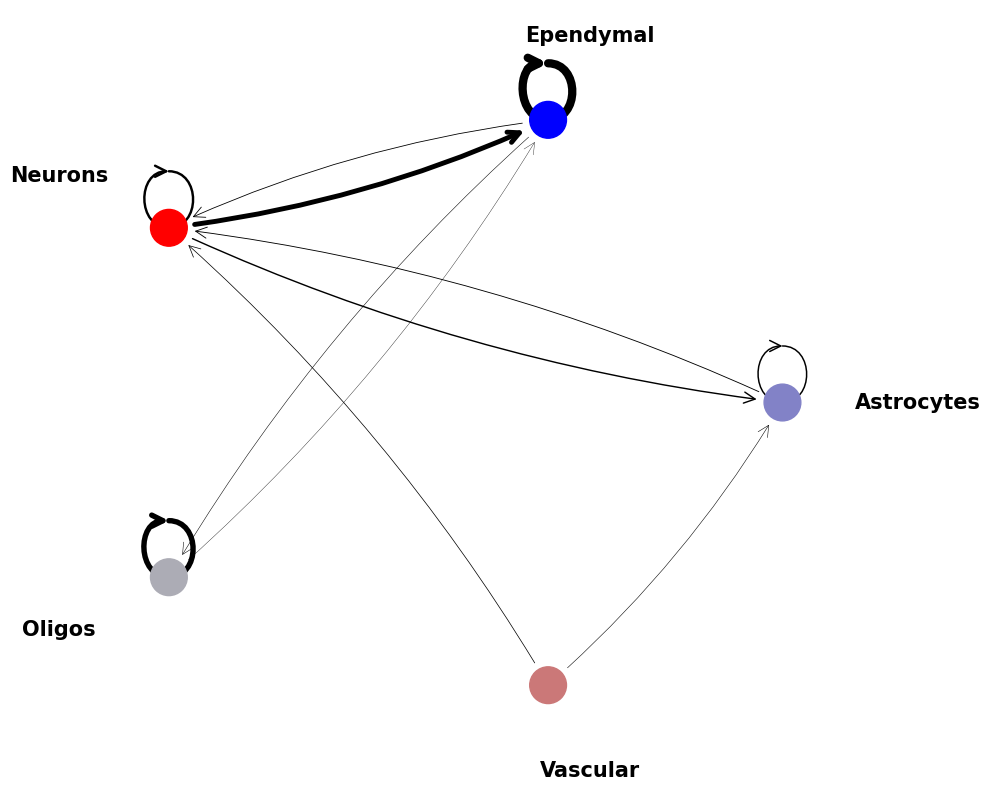


cluster5: Contains 120 LR pairs


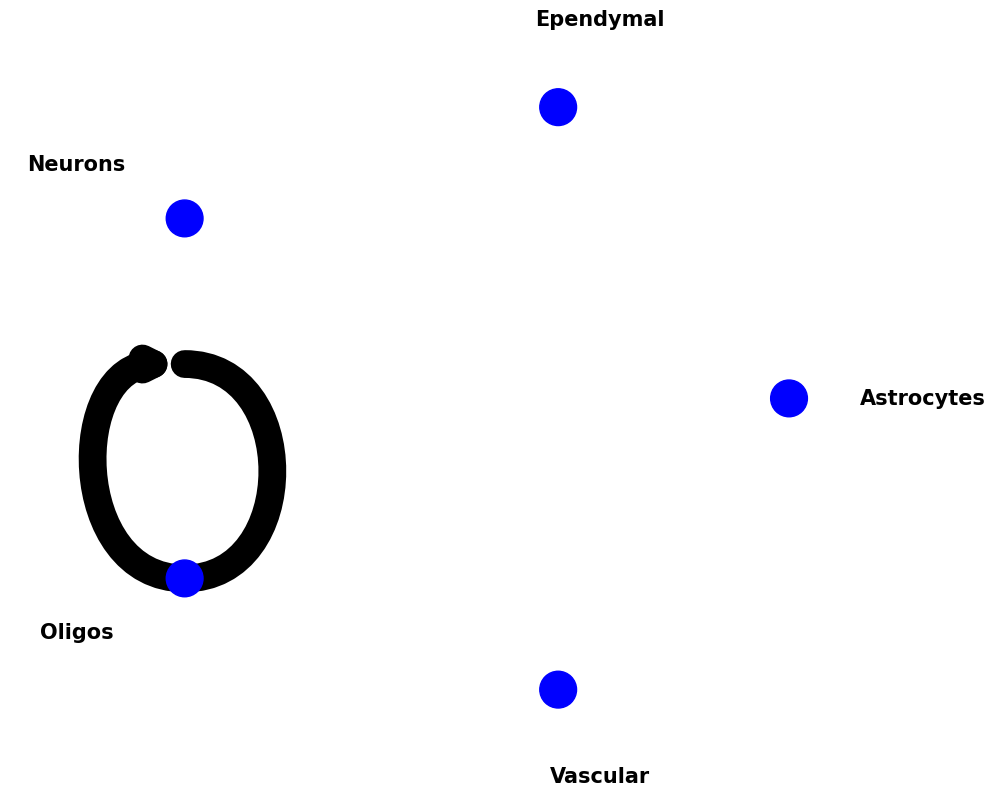


cluster6: Contains 47 LR pairs


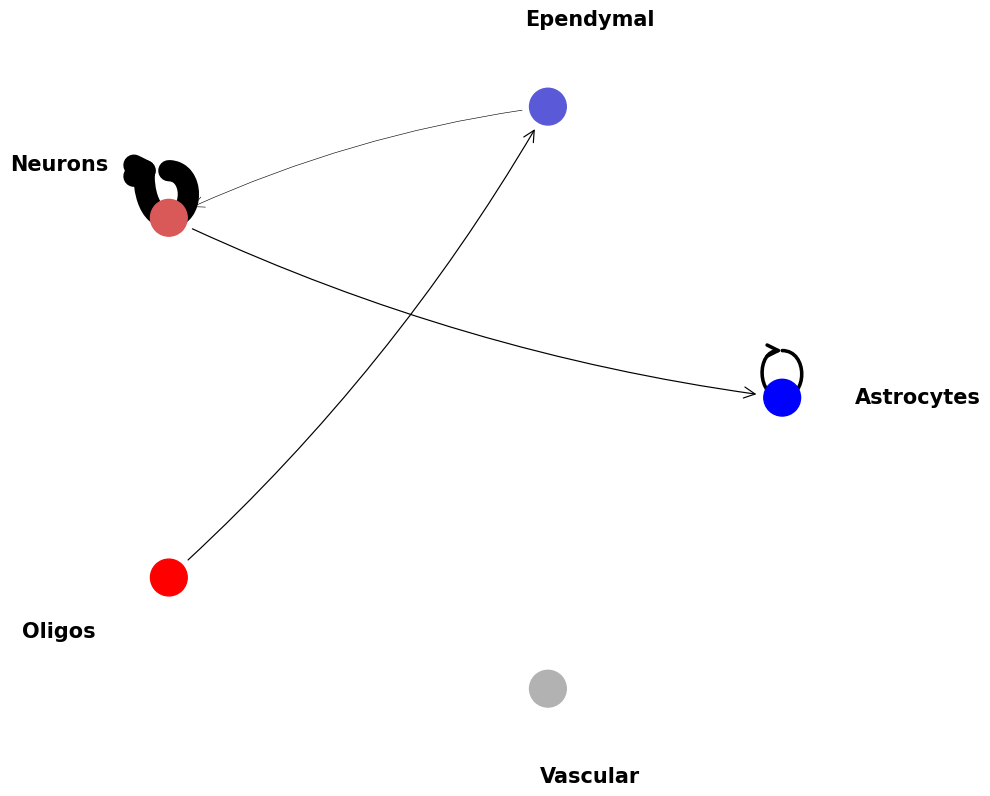


cluster8: Contains 21 LR pairs


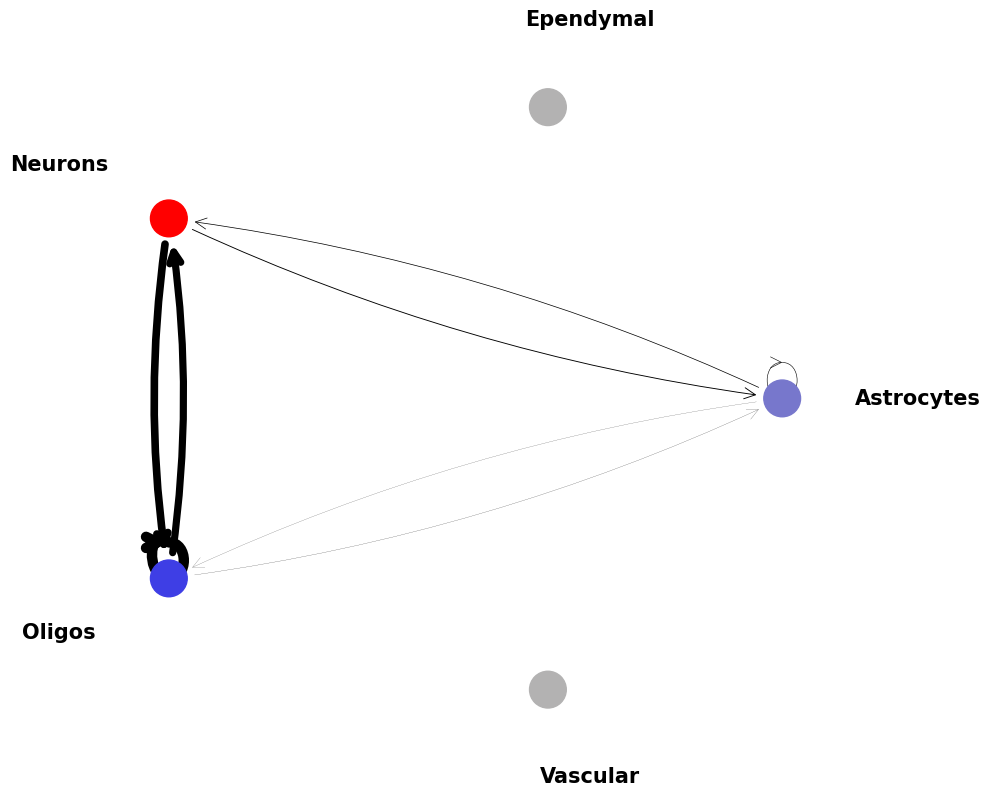


cluster9: Contains 38 LR pairs


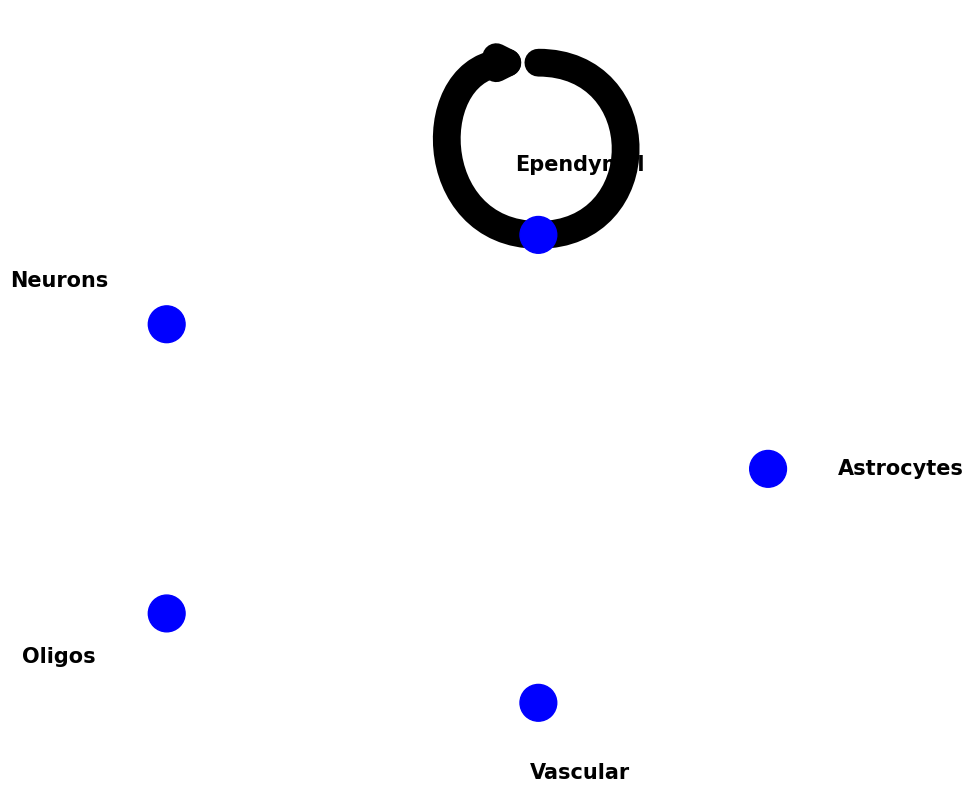

In [17]:
for cluster, matrix in young_overall_clusters.items():
    if matrix is not None:
        print("\ncluster" + str(cluster) + ": Contains " + str(len(young_integrated_clusters[cluster])) + " LR pairs")
        mmcci.plt.network_plot(matrix)

In [2]:
import os
import pandas as pd

def load_csv_files(directory):
    dataframes = {}

    # List all CSV files in the directory
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    for csv_file in csv_files:
        # Extract the key (file name without .csv extension)
        key = os.path.splitext(csv_file)[0]

        # Construct the full path to the CSV file
        file_path = os.path.join(directory, csv_file)

        # Read the CSV file into a pandas DataFrame
        dataframe = pd.read_csv(file_path, index_col=0)

        # Store the DataFrame in the dictionary with the key
        dataframes[key] = dataframe

    return dataframes


def transform_dataframe(original_dict):
    """Transforms a dictionary of DataFrames to the desired format.

    Args:
    original_dict: A dictionary where keys are strings and values are DataFrames.

    Returns:
    A dictionary where keys are formatted as 'ligand_receptor' and values are
    DataFrames with 'celltype' as columns and 'celltype1', 'celltype2' as indices.
    """

    transformed_dict = {}

    # Get all unique ligands and receptors across all DataFrames
    all_ligands = set()
    all_receptors = set()
    all_cell_types = set()

    for key, df in original_dict.items():
        for index in df.index:
            all_ligands.add(index)
        for column in df.columns:
            all_receptors.add(column)
        all_cell_types.update(key.split("_"))

    # Initialize the transformed dictionary with zero-filled DataFrames
    for ligand in all_ligands:
        for receptor in all_receptors:
            transformed_dict[f"{ligand}_{receptor}"] = pd.DataFrame(0, index=list(all_cell_types), columns=list(all_cell_types), dtype="float")

    # Update the values in the transformed dictionary
    for key, df in original_dict.items():
        celltype1, celltype2 = key.split("_")

        for ligand in df.index:
            for receptor in df.columns:
                ligand_receptor = f"{ligand}_{receptor}"
                transformed_dict[ligand_receptor].loc[celltype1, celltype2] = df.loc[ligand, receptor]

    non_zero_transformed_dict = {}
    for key, df in transformed_dict.items():
        if df.sum().sum() > 0:
            non_zero_transformed_dict[key] = df
            
    return non_zero_transformed_dict

# Replace 'your_directory_path' with the path to your CSV files directory
csv_path = "/home/uqlhocke/nichenet_files/"
result_dict = transform_dataframe(load_csv_files(csv_path))

In [3]:
result_dict

{'Klre1_H2.T23':        CD4 T  CD8 T  Mono  Treg   DC        NK    B
 CD4 T    0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 CD8 T    0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 Mono     0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 Treg     0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 DC       0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 NK       0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 B        0.0    0.0   0.0   0.0  0.0  0.915203  0.0,
 'Klre1_H2.Q4':        CD4 T  CD8 T  Mono  Treg   DC        NK    B
 CD4 T    0.0    0.0   0.0   0.0  0.0  0.000000  0.0
 CD8 T    0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 Mono     0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 Treg     0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 DC       0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 NK       0.0    0.0   0.0   0.0  0.0  0.915203  0.0
 B        0.0    0.0   0.0   0.0  0.0  0.915203  0.0,
 'Klre1_H2.D1':        CD4 T  CD8 T  Mono  Treg   DC        NK    B
 CD4 T    0.0    0.0   0.0   0.0  0.0  0.915203  0.